In [13]:
import ctypes
import numpy as np
import matplotlib.pyplot as plt

In [16]:
mlp_model = ctypes.CDLL("modele/mlp/target/release/libmlp_classification.so")

# Définir les types d'arguments et de retour des fonctions C
mlp_model.mlpInit.argtypes = [ctypes.POINTER(ctypes.c_uint), ctypes.c_size_t, ctypes.c_double]
mlp_model.mlpInit.restype = ctypes.POINTER(ctypes.c_void_p)

mlp_model.mlpTrain.argtypes = [
    ctypes.POINTER(ctypes.c_void_p),
    ctypes.POINTER(ctypes.c_double),
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_size_t,
    ctypes.c_bool
]
mlp_model.mlpTrain.restype = None


mlp_model.mlpBackward.argtypes = [
    ctypes.POINTER(ctypes.c_void_p),
    ctypes.POINTER(ctypes.c_double),
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t,
    ctypes.c_bool
]
mlp_model.mlpBackward.restype = ctypes.c_double

mlp_model.mlpUpdateWeights.argtypes = [ctypes.POINTER(ctypes.c_void_p), ctypes.c_double]
mlp_model.mlpUpdateWeights.restype = None

mlp_model.mlpForward.argtypes = [
    ctypes.POINTER(ctypes.c_void_p),
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t,
    ctypes.c_bool
]
mlp_model.mlpForward.restype = ctypes.POINTER(ctypes.c_double)


mlp_model.mlpPredict.argtypes = [
    ctypes.POINTER(ctypes.c_void_p),
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t,
    ctypes.c_bool,
    ctypes.POINTER(ctypes.c_double)
]
mlp_model.mlpPredict.restype = None

mlp_model.mlpFree.argtypes = [ctypes.POINTER(ctypes.c_void_p)]
mlp_model.mlpFree.restype = None


In [27]:
parameter = np.array([2, 3, 1], dtype=np.uintp)
learning_rate = 0.01
epochs = 100000
parameter_ptr = parameter.ctypes.data_as(ctypes.POINTER(ctypes.c_uint))
nn = mlp_model.mlpInit(parameter_ptr, parameter.size, learning_rate)

X_train = np.array([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0]
], dtype=np.float64)

y_train = np.array([
    [-1.0],
    [1.0],
    [1.0],
    [-1.0]
], dtype=np.float64)

layer : 2
neural matrix : [NeuralMatrix { matrix: [[-0.3338119710298133, 0.4878312006149472], [0.5273773279647744, 0.8585058101269558], [-0.6694291133156929, -0.10367661887602919]], bias: [0.0, 0.0, 0.0], input_size: 2, output_size: 3 }, NeuralMatrix { matrix: [[-0.7723849847067554, 0.7702260747489023, 0.35157248084715764]], bias: [0.0], input_size: 3, output_size: 1 }]


In [28]:
mlp_model.mlpTrain(
    nn,
    X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X_train.shape[0],
    X_train.shape[1],
    epochs,  # epochs
    True   # is_classification
)

In [29]:
for k in range(len(X_train)):
    predictions = np.zeros(1, dtype=np.float64)
    mlp_model.mlpPredict(
        nn,
        X_train[k].ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X_train[k].size,
        True,
        predictions.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    )
    print("Sample", X_train[k], ", predictions =", predictions)


Sample [0. 0.] , predictions = [-1.]
Sample [0. 1.] , predictions = [-1.]
Sample [1. 0.] , predictions = [-1.]
Sample [1. 1.] , predictions = [-1.]


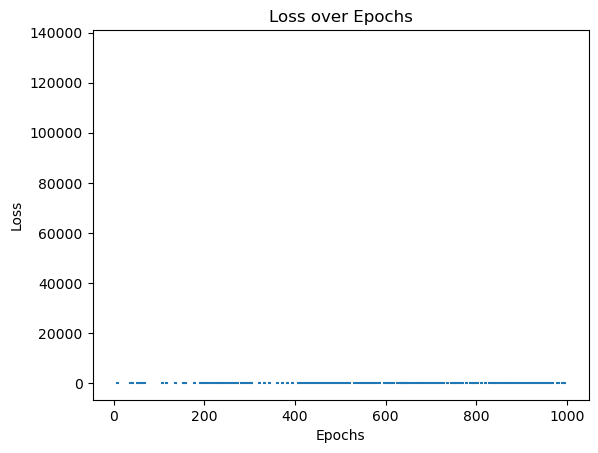

In [25]:
losses = []
for epoch in range(1000):
    epoch_loss = 0.0
    for x, y in zip(X_train, y_train):
        activations_ptr = mlp_model.mlpForward(
            nn,
            x.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            x.size,
            True
        )
        activations = np.ctypeslib.as_array(activations_ptr, shape=(1,))

        loss = mlp_model.mlpBackward(
            nn,
            activations.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
            len(parameter),
            True
        )
        epoch_loss += loss

        mlp_model.mlpUpdateWeights(nn, learning_rate)

    losses.append(epoch_loss / len(X_train))

plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()


In [26]:
mlp_model.mlpFree(nn)